In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from numpy.typing import NDArray

from karabo.imaging.image import Image
from karabo.imaging.imager import Imager
from karabo.imaging.imager_wsclean import WscleanImager, WscleanImagerConfig
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.simulator_backend import SimulatorBackend
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
SIMULATOR_BACKEND = SimulatorBackend.OSKAR

## Simulation

/home/michel/karabo/Karabo-Pipeline/karabo/simulation/sky_model.py:1223: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


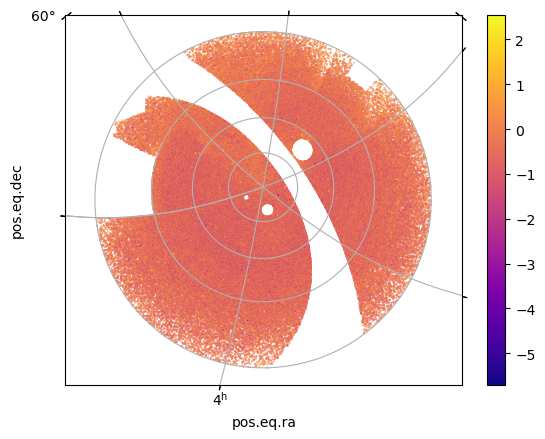

In [3]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky(min_freq=72e6, max_freq=80e6)
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [4]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

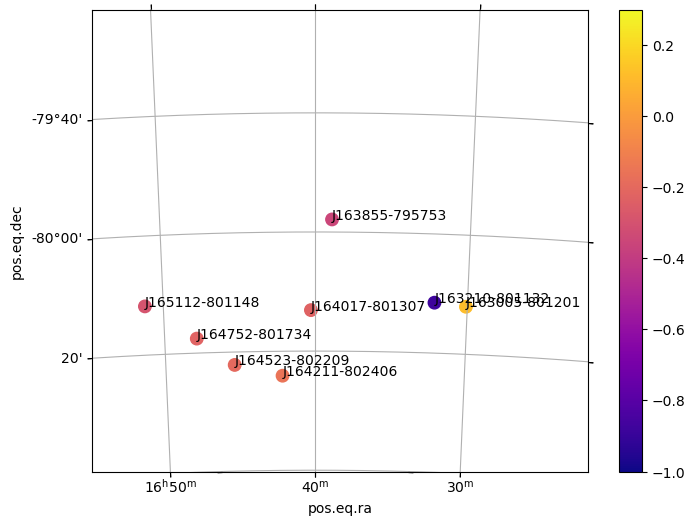

In [5]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

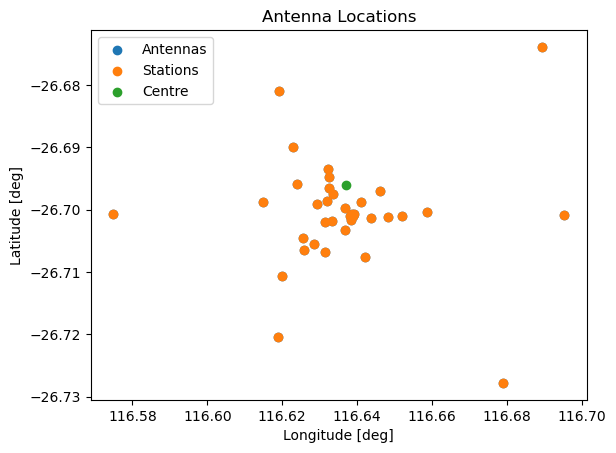

In [6]:
askap_tel = Telescope.constructor("ASKAP", backend=SIMULATOR_BACKEND)
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [7]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    start_date_and_time=datetime(2024, 3, 15, 10, 46, 0),
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=16,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.vis_path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path, channel_bandwidth_hz=1e6
)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel,
    sky,
    observation_settings,
    backend=SIMULATOR_BACKEND
)

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/visibility-fGvDfqJus7 for visibility disk-cache
Saving file to /tmp/karabo-STM-michel-dVM6tqMIQ3/visibility-fGvDfqJus7/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-michel-dVM6tqMIQ3/visibility-fGvDfqJus7/visibility.vis


### Imaging

In [8]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

In [9]:
# imager_config_tuples = [
#     (WscleanImager(), WscleanImagerConfig()),
#     (RascilImager(), RascilImagerConfig()),
#     (OskarImager(), OskarImagerConfig()),
# ]

In [10]:
# for imager, config in imager_config_tuples:
#     dirty_image = imager.create_dirty_image(config)
#     dirty_image.plot(title=f"Dirty image {imager.__class__.__name__}")

In [11]:
# for imager, config in imager_config_tuples:
#     _, restored_image, _ = imager.create_cleaned_image(config)
#     restored_image.plot(title=f"Cleaned image {imager.__class__.__name__}")

#### RASCIL

We can create dirty images of visibilites and display them as shown below

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imager-Dirty-qV5mXjWjXS for disk-cache for dirty.fits


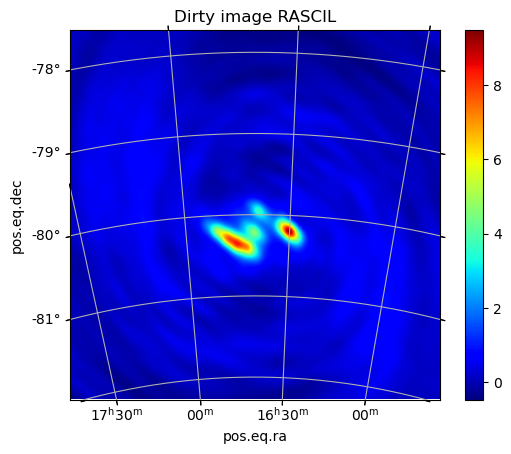

In [12]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image(
    imaging_backend=SimulatorBackend.RASCIL,
)
dirty.plot(title="Dirty image RASCIL")

Run clean algorithm and display restored image

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imaging-Rascil-4WCfOlIHsC for disk-cache for non-specified .fits files.
Dashboard link: http://172.20.89.46:8787/status
LocalCluster(0f356e94, 'inproc://172.20.89.46/213225/1', workers=1, threads=16, memory=11.68 GiB)


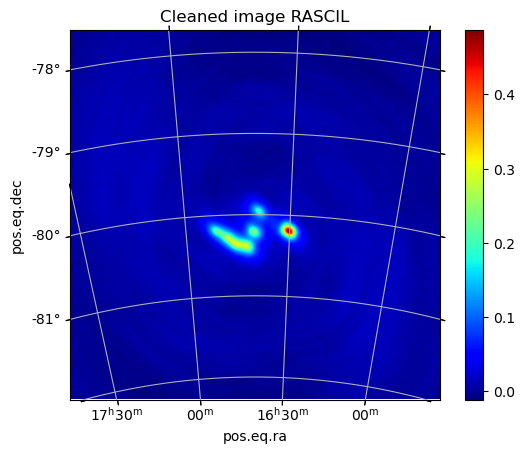

In [13]:
imager_askap.ingest_chan_per_vis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=1,
    clean_algorithm="mmclean",
    clean_scales=[10, 30, 60],
    clean_fractional_threshold=0.3,
    clean_threshold=0.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output="integrated",
    use_dask=True,
)
restored.plot(title="Cleaned image RASCIL")

#### WSClean

In [14]:
imager_wsclean = WscleanImager()
imager_config = WscleanImagerConfig(
    ms_file_path=visibility_askap.ms_file_path,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-wYT5qgn2rS for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-dirty-wYT5qgn2rS && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS]


WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 11.7 GB of system memory, usage not limited.
Opening /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Determining min and max w & theoretical beam size... DONE (w=[0.00172035:1905.5] lambdas, maxuvw=2148.94 lambda)
Theoretic beam = 95.98''
Minimal i

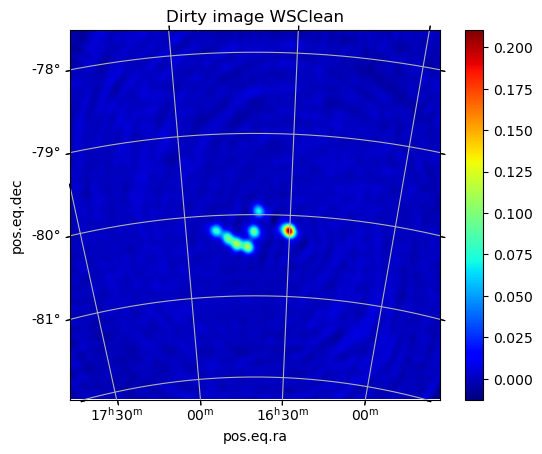

In [15]:
dirty_wsclean = imager_wsclean.create_dirty_image(imager_config)
dirty_wsclean.plot(title="Dirty image WSClean")

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-tyhMF0l62g for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-tyhMF0l62g && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS]


WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for uniform weighting...
Opening reordered part 0 spw 0 for /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS
Detected 11.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt

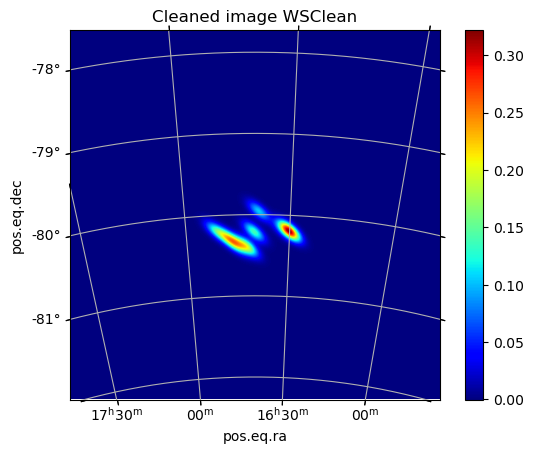

In [16]:
deconvolved_wsclean, restored_wsclean, residual_wsclean = imager_wsclean.create_cleaned_image(imager_config)
restored_wsclean.plot(title="Cleaned image WSClean")

In [17]:
import math

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-XjAjXpBvav for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-XjAjXpBvav && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0

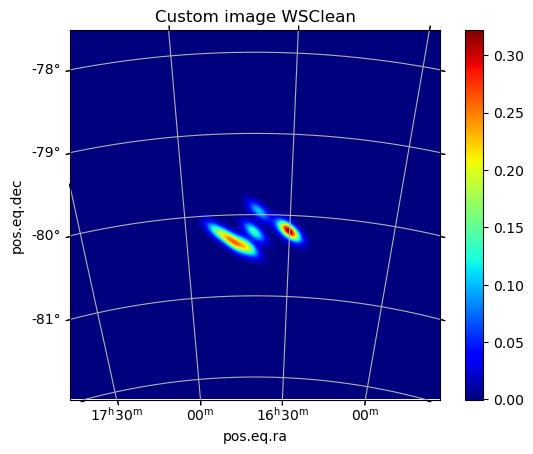

In [18]:
custom_wsclean = imager_wsclean.create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibility_askap.ms_file_path}"
)
custom_wsclean.plot(title="Custom image WSClean")

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-FDd0wPgf6R for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-custom-FDd0wPgf6R && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-Xo0rE821Bt/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0

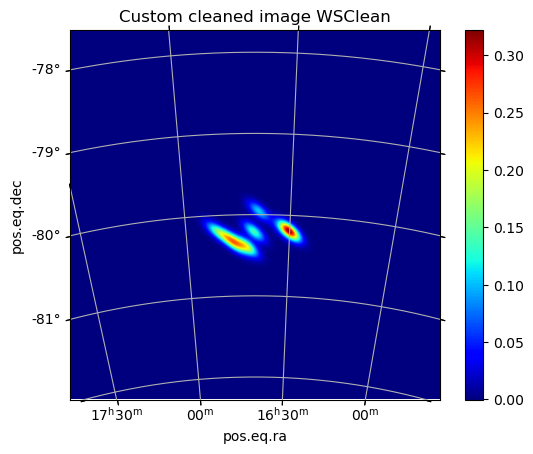

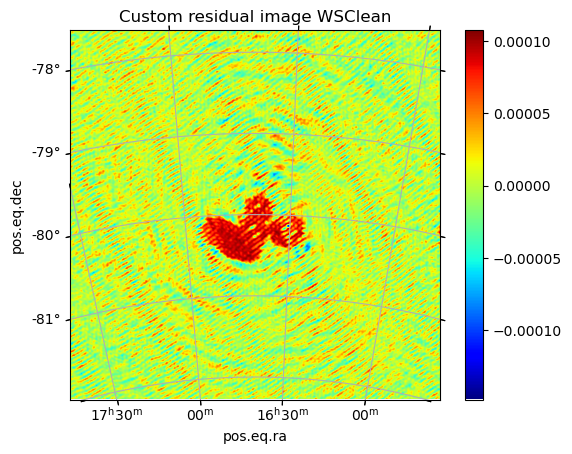

In [19]:
custom_restored_wsclean, custom_residual_wsclean = imager_wsclean.create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibility_askap.ms_file_path}",
    
    ['wsclean-image.fits', 'wsclean-residual.fits']
)
custom_restored_wsclean.plot(title="Custom cleaned image WSClean")
custom_residual_wsclean.plot(title="Custom residual image WSClean")

### Source Detection

In [20]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

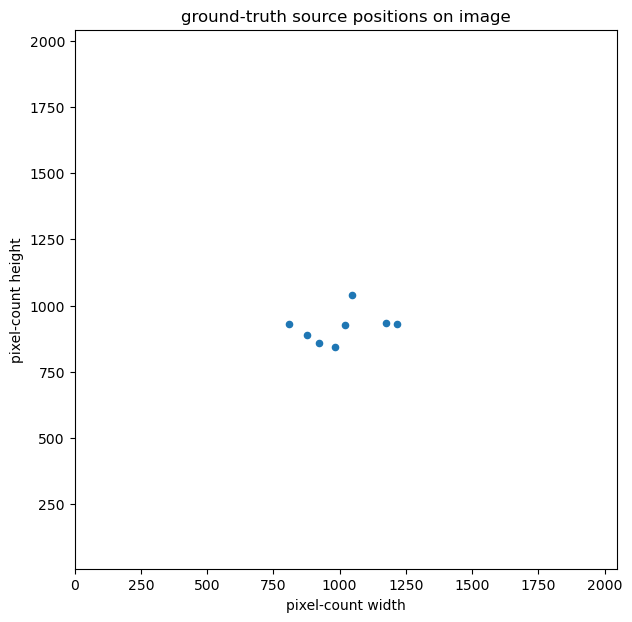

In [21]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [22]:
def detect_sources_and_evaluate(
    image: Image,
    ground_truth: NDArray[np.float64],
    sky: SkyModel, sky_idxs: NDArray[np.int64]
) -> SourceDetectionEvaluation:
    detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
        image=image,
        thresh_isl=15,
        thresh_pix=20,
    )

    assignments = (
        SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
            ground_truth=ground_truth.T,
            detected=detection_result.get_pixel_position_of_sources(),
            max_dist=10,
            top_k=3,
        )
    )
    print(assignments)

    sde = SourceDetectionEvaluation(
        sky=sky,
        ground_truth=ground_truth,
        assignments=assignments,
        sky_idxs=sky_idxs,
        source_detection=detection_result,
    )
    sde.plot()

    sde.plot_confusion_matrix()

    return sde

#### RASCIL

Source detection on dirty image

/home/michel/karabo/Karabo-Pipeline/karabo/sourcedetection/result.py:170: KaraboWarning: No beam parameter provided by `beam` or found in image header. guessing parameters using `Imager.guess_beam_parameters`.
  warn(


Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-b8wpo3TuY2 for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-b8wpo3TuY2/sources.csv'
--> Wrote file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-b8wpo3TuY2/ch0-result.fits'
[[ 0.         -1.                 inf]
 [ 1.         -1.                 inf]
 [ 2.         -1.                 inf]
 [ 3.          0.          3.90722295]
 [ 4.         -1.                 inf]
 [ 5.         -1.                 inf]
 [ 6.         -1.                 inf]
 [ 7.         -1.                 inf]]


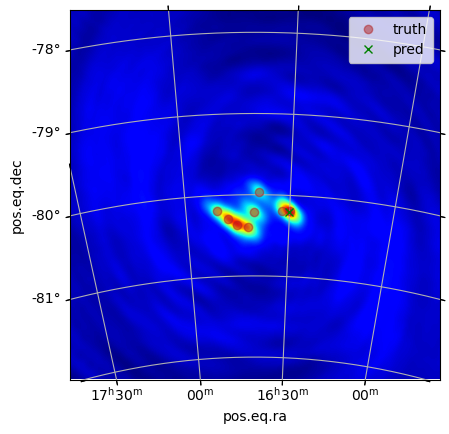

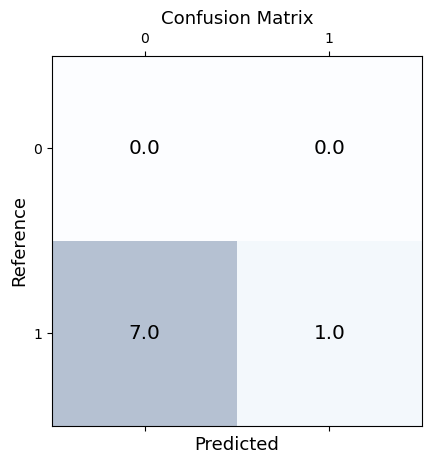

In [23]:
sde_dirty = detect_sources_and_evaluate(
    image=dirty,
    ground_truth=ground_truth,
    sky=sky, sky_idxs=sky_idxs
)

Source Detection on restored image.

2024-04-25 10:48:04,101 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-04-25 10:48:04,214 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
2024-04-25 10:48:04,327 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)


Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-3RsrjaqvfI for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-3RsrjaqvfI/sources.csv'
--> Wrote file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-3RsrjaqvfI/ch0-result.fits'
[[-1.          1.                 inf]
 [ 0.         -1.                 inf]
 [ 1.         -1.                 inf]
 [ 2.         -1.                 inf]
 [ 3.          3.          4.08969418]
 [ 4.          0.          4.51608123]
 [ 5.         -1.                 inf]
 [ 6.         -1.                 inf]
 [ 7.          2.          2.7555038 ]]


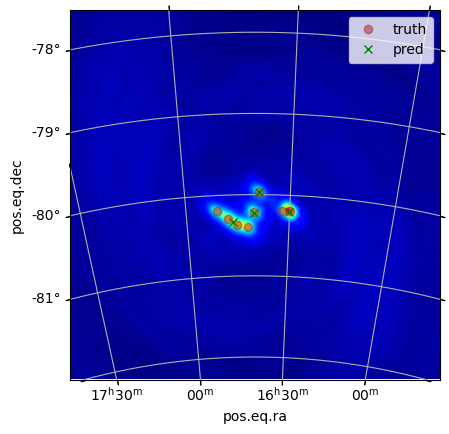

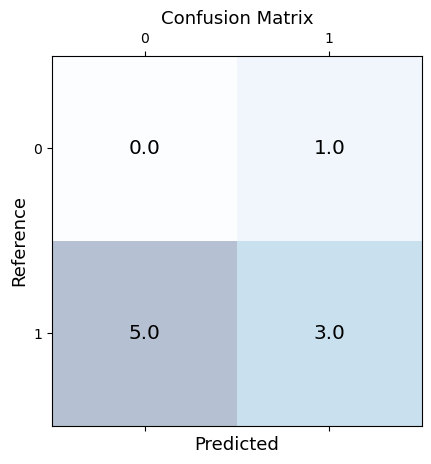

In [24]:
sde_restored = detect_sources_and_evaluate(
    image=restored,
    ground_truth=ground_truth,
    sky=sky, sky_idxs=sky_idxs
)

#### WSClean

2024-04-25 10:48:06,047 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2024-04-25 10:48:06,175 - distributed.utils_perf - WARNING - full garbage collections took 49% CPU time recently (threshold: 10%)
2024-04-25 10:48:06,969 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2024-04-25 10:48:07,140 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2024-04-25 10:48:07,247 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2024-04-25 10:48:07,474 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)


Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-CoclCNGup4 for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-CoclCNGup4/sources.csv'
--> Wrote file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-CoclCNGup4/ch0-result.fits'
[[0.         4.         1.33767548]
 [1.         7.         2.88743307]
 [2.         1.         3.25858618]
 [3.         0.         1.38755972]
 [4.         2.         1.40559103]
 [5.         6.         6.83117286]
 [6.         5.         1.33944926]
 [7.         3.         1.40009929]]


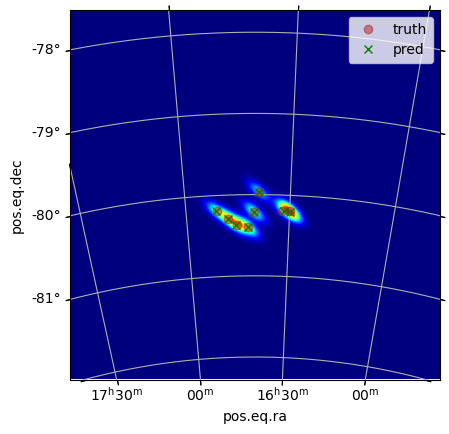

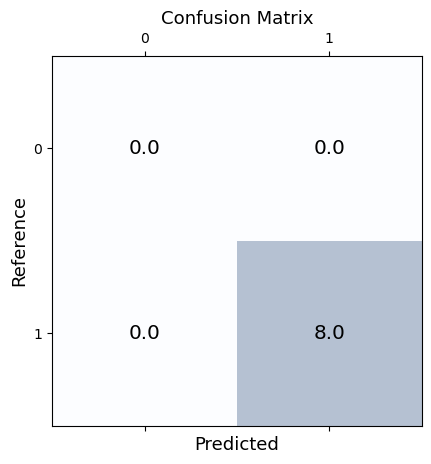

In [25]:
sde_restored_wsclean = detect_sources_and_evaluate(
    image=restored_wsclean,
    ground_truth=ground_truth,
    sky=sky, sky_idxs=sky_idxs
)

#### Additional plots

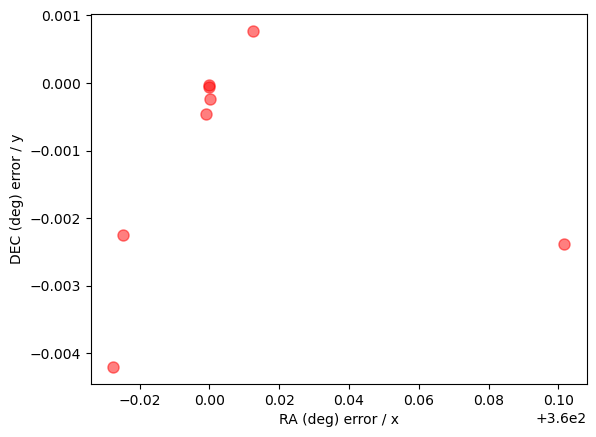

In [26]:
# Plot error ra and dec
sde_restored_wsclean.plot_error_ra_dec()

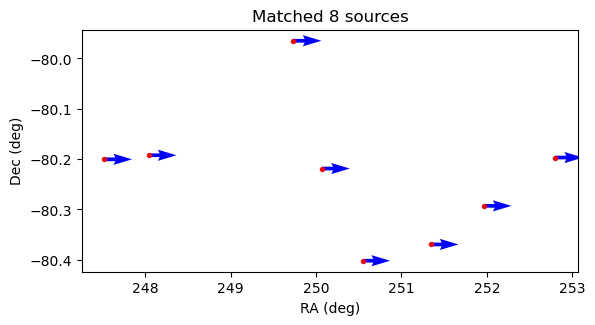

In [27]:
sde_restored_wsclean.plot_quiver_positions()

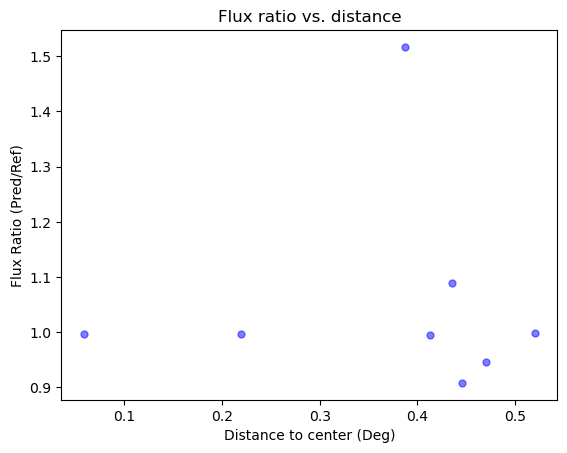

In [28]:
sde_restored_wsclean.plot_flux_ratio_to_distance()

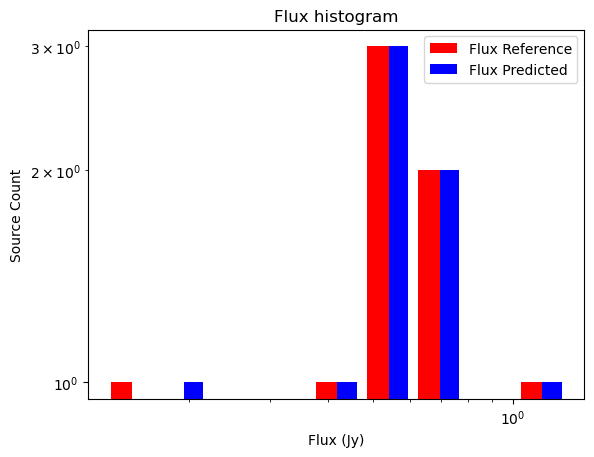

In [29]:
sde_restored_wsclean.plot_flux_histogram()

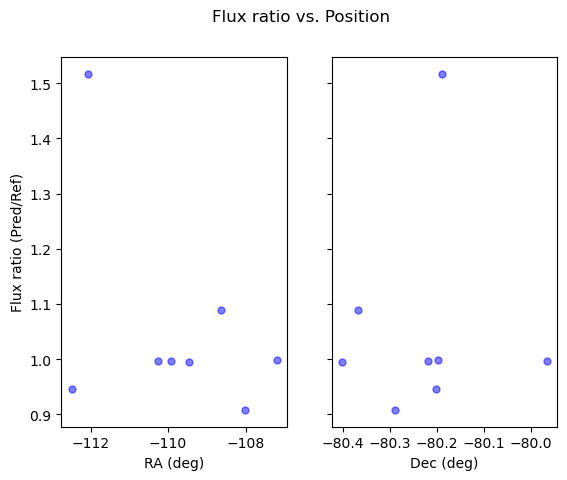

In [30]:
sde_restored_wsclean.plot_flux_ratio_to_ra_dec()